In [27]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import sys
from ipywidgets import widgets
from IPython.display import display, HTML
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# Customized modules
HOME = '/home/serinatan/project/GPU-Virtualization-Benchmarks/util'
if HOME not in sys.path:
    sys.path.append(HOME)

import data.scripts.common.format as fmt
import data.scripts.common.constants as const
import data.scripts.gen_graphs.gen_altair_timeline as gen_altair

SCRIPT_PATH = os.path.join(HOME, 'data/scripts') 
PKL_PATH = os.path.join(HOME, 'data/pickles') 
CSV_PATH = os.path.join(HOME, 'data/csv')

%config InlineBackend.figure_format ='retina'
plt.style.use('seaborn-talk')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
def draw_table(df, cols, hide_index=True):
    if hide_index:
        return df[cols].style.set_table_styles(fmt.table_style).hide_index()
    else:
        return df[cols].style.set_table_styles(fmt.table_style)

# Inter-SM sharing pairs

In [380]:
gen_pair = os.path.join(SCRIPT_PATH, 'gen_tables/gen_table_pair.py')
baseline = 'seq'
seq_pkl = os.path.join(PKL_PATH, 'seq.pkl')
inter_pkl = os.path.join(PKL_PATH, 'inter.pkl')
csv = os.path.join(HOME, 'data/csv/pair_inter.csv')
output = os.path.join(PKL_PATH, 'pair_inter.pkl')

%run $gen_pair --csv $csv --output $output --seq_pkl $seq_pkl --how inter --isolated_pkl $inter_pkl

In [10]:
output = os.path.join(PKL_PATH, 'pair_inter.pkl')
df_inter = pd.read_pickle(output)
print(df_inter.shape)
df_inter.sort_values(['1_bench', '2_bench'], inplace=True)
df_inter.reset_index(inplace=True, drop=True)

# FIXME: drop any rows with zero fairness
df_inter = df_inter[df_inter['fairness'] > 0]


(494, 233)


In [15]:
# Only show best performance for each benchmark pair
df_inter_show = df_inter.sort_values('ws', ascending=False).drop_duplicates(['1_bench','2_bench'])
df_inter_show.reset_index(inplace=True, drop=True)
# df_inter_show = df_inter_show[(df_inter_show['1_bench']=='parb_lbm-0')|(df_inter_show['2_bench']=='parb_lbm-0')]

# df_inter_show['delta'] = df_inter_show['norm_ipc_sum'] - df_inter_show['ws']

col_inter_show = ['1_bench', '1_inter', '1_sld', 
                    '2_bench', '2_inter', '2_sld', 'ws', 'fairness']
draw_table(df_inter_show, col_inter_show, False).format({'avg_dram_bw_x':'{:.4f}',
                                                         'avg_dram_bw_y':'{:.4f}',
                                                        })

,1_bench,1_inter,1_sld,2_bench,2_inter,2_sld,ws,fairness
0,parb_cutcp-0,52,1.00309,rod_heartwall-0,28,1.05283,2.05591,0.952756
1,nvd_blackscholes-0,40,0.996233,parb_cutcp-0,40,0.971767,1.968,0.975442
2,nvd_interval-0,60,0.980353,parb_cutcp-0,20,0.985887,1.96624,0.994386
3,nvd_interval-0,52,0.955376,rod_heartwall-0,28,1.00699,1.96237,0.948743
4,parb_cutcp-0,20,0.971141,parb_spmv-0,60,0.983206,1.95435,0.987729
5,parb_cutcp-0,36,0.981885,parb_stencil-0,44,0.971572,1.95346,0.989497
6,nvd_blackscholes-0,44,1.01996,rod_heartwall-0,36,0.921436,1.9414,0.903405
7,parb_cutcp-0,16,0.959332,rod_streamcluster-0,64,0.974202,1.93353,0.984736
8,parb_cutcp-0,40,0.947682,parb_lbm-0,40,0.981951,1.92963,0.965101
9,cut_wmma-0,48,0.927393,parb_cutcp-0,32,0.992023,1.91942,0.93485


In [20]:
draw_table(df_inter_show[(df_inter_show['1_bench']=='cut_wmma-0')
                         &(df_inter_show['2_bench']=='nvd_binomial-0')], 
           col_inter_show)

1_bench,1_inter,1_sld,2_bench,2_inter,2_sld,ws,fairness
cut_wmma-0,32,0.829393,nvd_binomial-0,48,0.442129,1.27152,0.533076


=== inter-SM stats ===
** Total **
Pairs:  136
WS geomean: 1.3180
------------------------------
** Greater than 1.0 WS **
Proportion: 0.88
WS geomean: 1.3742
------------------------------
** Greater than 1.5 WS **
Proportion: 0.31
WS geomean:  1.7501


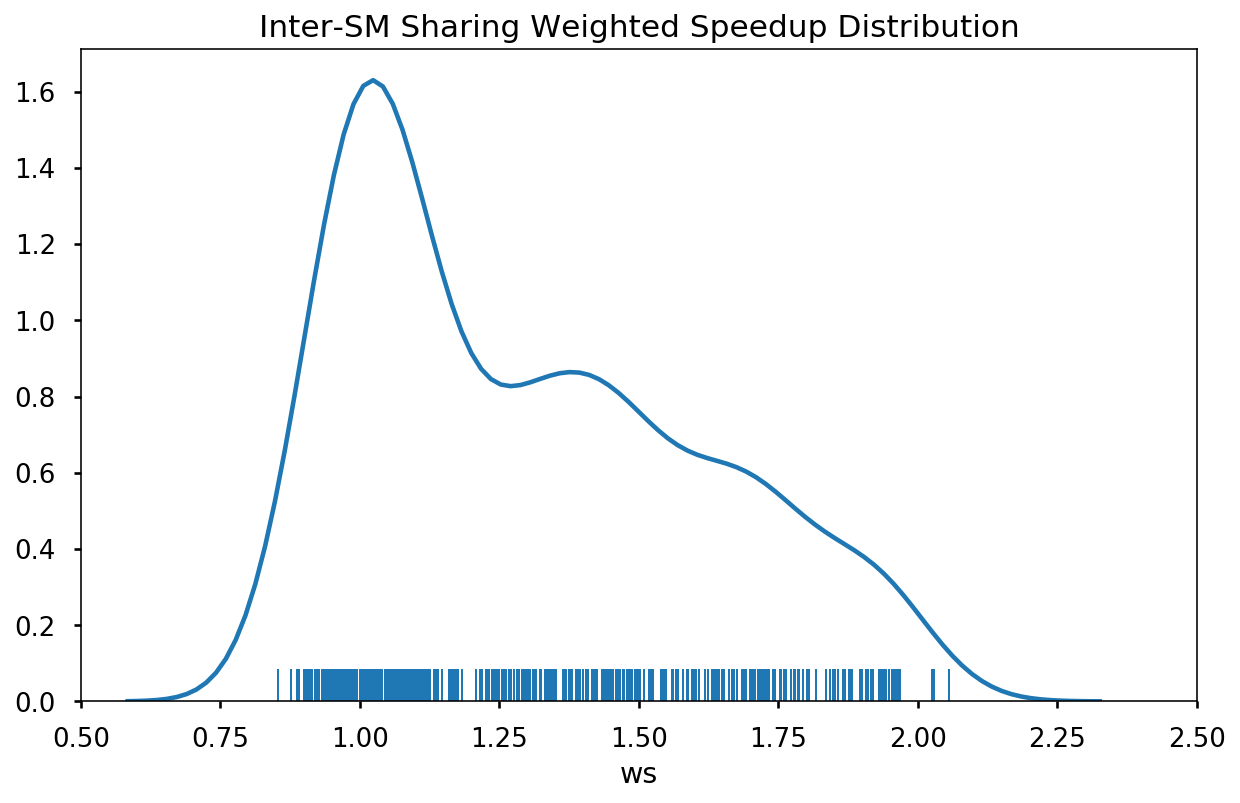

In [383]:
print('=== inter-SM stats ===')
print('** Total **')
print('Pairs: ', len(df_inter_show))
print('WS geomean: %.4f'% scipy.stats.mstats.gmean(df_inter_show['ws']))
# print('Naive prediction average delta: %.2f'% np.average(df_inter_show['delta']))

print('-'*30)

df_gt_1_inter = df_inter_show[df_inter_show['ws'] > 1.0]
print('** Greater than 1.0 WS **')
print('Proportion: %.2f' % (len(df_gt_1_inter.index)/len(df_inter_show.index)))
print('WS geomean: %.4f'% scipy.stats.mstats.gmean(df_gt_1_inter['ws']))
# print('Greater than 1.0 naive delta: %.2f'% np.average(df_gt_1_inter['delta']))

print('-'*30)

df_gt_15_inter = df_inter_show[df_inter_show['ws'] > 1.5]
print('** Greater than 1.5 WS **')
print('Proportion: %.2f' % (len(df_gt_15_inter.index)/len(df_inter_show.index)))
print('WS geomean:  %.4f'% scipy.stats.mstats.gmean(df_gt_15_inter['ws']))
# print('Greater than 1.5 naive delta:  %.2f'% np.average(df_gt_15_inter['delta']))

plt.figure(figsize=(10, 6))
sns.distplot(df_inter['ws'], hist=False, rug=True);
plt.xlim([0.5, 2.5])
plt.title('Inter-SM Sharing Weighted Speedup Distribution')
plt.show()

In [265]:
# print('=== Ideal inter-SM stats ===')
# # predicted norm_ipc_sum of inter-SM
# df_inter_max = df_inter.dropna()
# print('** Total **')
# print('norm_ipc_sum geomean: %.4f'% scipy.stats.mstats.gmean(df_inter_max['norm_ipc_sum']))

# print('-'*30)

# df_gt_1_inter = df_inter_max[df_inter_max['norm_ipc_sum'] > 1.0]
# print('** Greater than 1.0 norm_ipc_sum **')
# print('Proportion: %.2f' % (len(df_gt_1_inter.index)/len(df_inter_max.index)))
# print('norm_ipc_sum geomean: %.4f'% scipy.stats.mstats.gmean(df_gt_1_inter['norm_ipc_sum']))
# # print('Greater than 1.0 naive delta: %.2f'% np.average(df_gt_1_inter['delta']))

# print('-'*30)

# df_gt_15_inter = df_inter_max[df_inter_max['norm_ipc_sum'] > 1.5]
# print('** Greater than 1.5 norm_ipc_sum **')
# print('Proportion: %.2f' % (len(df_gt_15_inter.index)/len(df_inter_max.index)))
# print('norm_ipc_sum geomean:  %.4f'% scipy.stats.mstats.gmean(df_gt_15_inter['norm_ipc_sum']))
# # print('Greater than 1.5 naive delta:  %.2f'% np.average(df_gt_15_inter['delta']))

# plt.figure(figsize=(10, 6))
# sns.distplot(df_inter_max['norm_ipc_sum'], hist=False, rug=True);
# plt.title('(Ideal) Inter-SM Sharing Weighted Speedup Distribution')
# plt.show()

# Intra-SM sharing pairs

In [4]:
df_dynamic = pd.read_pickle(os.path.join(PKL_PATH, 'pair_dynamic.pkl'))
print(df_dynamic.shape)
df_dynamic.sort_values(['1_bench', '2_bench'], inplace=True)
df_dynamic.reset_index(inplace=True, drop=True)


(1212, 248)


In [7]:
# Only show best performance for each benchmark pair
df_dynamic_show = df_dynamic.sort_values('ws', ascending=False).drop_duplicates(['1_bench','2_bench'])
df_dynamic_show.reset_index(inplace=True, drop=True)

col_dynamic_show = ['1_bench', '1_intra', 
                    '2_bench', '2_intra', 'sld', 'ws', 'fairness']
draw_table(df_dynamic_show, col_dynamic_show, False).format({'avg_dram_bw_x':'{:.4f}',
                                                             'avg_dram_bw_y':'{:.4f}',
                                                             'sum_bw_x':'{:.4f}'
                                                            })

,1_bench,1_intra,2_bench,2_intra,sld,ws,fairness
0,nvd_binomial-0,8,parb_spmv-0,8,"[0, 0.9676630385607476, 1.0714552710878016]",2.03912,0.90313
1,nvd_interval-0,6,parb_cutcp-0,2,"[0, 1.0643573358887144, 0.940648309057575]",2.00501,0.883771
2,parb_cutcp-0,2,parb_spmv-0,6,"[0, 0.9670047333427468, 1.0369807505298978]",2.00399,0.932519
3,parb_cutcp-0,2,parb_stencil-0,4,"[0, 0.9690736237554929, 1.0309441374692916]",2.00002,0.939987
4,nvd_interval-0,6,rod_heartwall-0,1,"[0, 1.0587837412697414, 0.9322560596643878]",1.99104,0.880497
5,nvd_blackscholes-0,4,parb_cutcp-0,2,"[0, 1.0170875782129234, 0.969612001305025]",1.9867,0.953322
6,nvd_binomial-0,13,rod_heartwall-0,1,"[0, 1.058975062078211, 0.9241545391757177]",1.98313,0.872688
7,nvd_blackscholes-0,6,rod_lavamd-0,6,"[0, 0.9069906266968081, 1.0630824756536166]",1.97007,0.853171
8,parb_cutcp-0,2,rod_heartwall-0,1,"[0, 0.9952028710114091, 0.9637049099872844]",1.95891,0.96835
9,parb_stencil-0,4,rod_lavamd-0,6,"[0, 0.88950235676058, 1.0679177044032913]",1.95742,0.832932


In [55]:
draw_table(df_dynamic_show[(df_dynamic_show['1_bench']=='nvd_binomial-0')&
                           (df_dynamic_show['2_bench']=='parb_stencil-0')], 
           col_dynamic_show)

1_bench,1_intra,2_bench,2_intra,sld,ws,fairness
nvd_binomial-0,8,parb_stencil-0,4,"[0, 0.9062368207147891, 0.9944963950130805]",1.90073,0.911252


=== intra-SM stats ===
** Total **
Pairs:  168
WS geomean: 1.4274
------------------------------
** Greater than 1.0 WS **
Proportion: 0.93
WS geomean: 1.4680
------------------------------
** Greater than 1.5 WS **
Proportion: 0.45
WS geomean: 1.7425


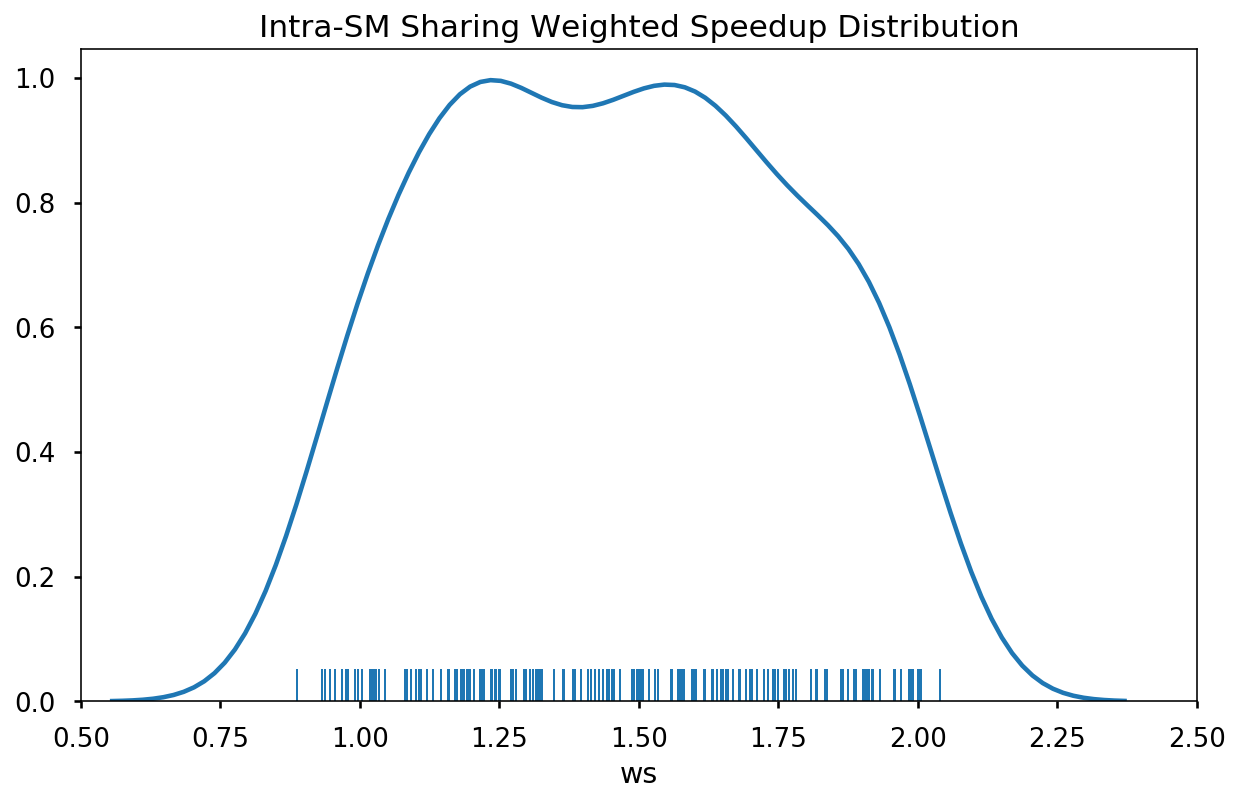

In [8]:
print('=== intra-SM stats ===')
print('** Total **')
print('Pairs: ', len(df_dynamic_show.index))
print('WS geomean: %.4f' % scipy.stats.mstats.gmean(df_dynamic_show['ws']))
# print('Naive prediction average delta: %.2f' % np.average(df_dynamic_show['delta']))

print('-'*30)

df_gt_1_intra = df_dynamic_show[df_dynamic_show['ws'] > 1.0]
print('** Greater than 1.0 WS **')
print('Proportion: %.2f' % (len(df_gt_1_intra.index)/len(df_dynamic_show.index)))
print('WS geomean: %.4f' % scipy.stats.mstats.gmean(df_gt_1_intra['ws']))
# print('Greater than 1.0 naive delta: %.2f' % np.average(df_gt_1_intra['delta']))

print('-'*30)

df_gt_15_intra = df_dynamic_show[df_dynamic_show['ws'] > 1.5]
print('** Greater than 1.5 WS **')
print('Proportion: %.2f' % (len(df_gt_15_intra.index)/len(df_dynamic_show.index)))
print('WS geomean: %.4f' % scipy.stats.mstats.gmean(df_gt_15_intra['ws']))
# print('Greater than 1.5 naive delta: %.2f' % np.average(df_gt_15_intra['delta']))

plt.figure(figsize=(10, 6))
sns.distplot(df_dynamic_show['ws'], hist=False, rug=True);
plt.xlim([0.5, 2.5])
plt.title('Intra-SM Sharing Weighted Speedup Distribution')
plt.show()

In [266]:
# print('=== Ideal intra-SM stats ===')
# print('** Total **')
# print('WS geomean: %.4f' % scipy.stats.mstats.gmean(df_dynamic_show['sum_ipc']))

# print('-'*30)

# df_gt_1_intra = df_dynamic_show[df_dynamic_show['sum_ipc'] > 1.0]
# print('** Greater than 1.0 WS **')
# print('Proportion: %.2f' % (len(df_gt_1_intra.index)/len(df_dynamic_show.index)))
# print('WS geomean: %.4f' % scipy.stats.mstats.gmean(df_gt_1_intra['sum_ipc']))

# print('-'*30)

# df_gt_15_intra = df_dynamic_show[df_dynamic_show['sum_ipc'] > 1.5]
# print('** Greater than 1.5 WS **')
# print('Proportion: %.2f' % (len(df_gt_15_intra.index)/len(df_dynamic_show.index)))
# print('WS geomean: %.4f' % scipy.stats.mstats.gmean(df_gt_15_intra['sum_ipc']))

# plt.figure(figsize=(10, 6))
# sns.distplot(df_dynamic_show['sum_ipc'], hist=False, rug=True);
# plt.title('(Ideal) Intra-SM Sharing Weighted Speedup Distribution')
# plt.show()

# Compare Inter-SM and Intra-SM

In [384]:
df_both = pd.merge(df_inter_show, df_dynamic_show, on=['1_bench', '2_bench'], suffixes=('_inter', '_intra'))
df_both['intra-inter'] = df_both['ws_intra'] - df_both['ws_inter']
df_both['diff_mf_lat'] = np.absolute(df_both['1_avg_mem_lat_intra'] - df_both['2_avg_mem_lat_intra'])

# for c in df_both.columns:
#     print(c)
    

col_both = ['1_bench', '2_bench', #'ws_inter', 'ws_intra', 
            'intra-inter', 
            '1_sld_inter', '2_sld_inter', '1_sld_intra', '2_sld_intra',
#             'avg_dram_bw_x_intra', 'avg_dram_bw_y_intra',
#             'scoreboard_cycles_x_intra', 'scoreboard_cycles_y_intra',
#             'l2_BW_x_intra', 'l2_BW_y_intra',
            '1_conc_cta_delta', '2_conc_cta_delta',
            '1_intra', '2_intra', '1_inter', '2_inter',
           ]

df_both['1_conc_cta_delta'] = df_both['1_conc_cta_intra'] - df_both['1_conc_cta_inter']
df_both['2_conc_cta_delta'] = df_both['2_conc_cta_intra'] - df_both['2_conc_cta_inter']

def highlight_error(s):
    is_neg = s < 0
    return ['background-color: yellow' if v else '' for v in is_neg]


df_both_display = df_both#[df_both['intra-inter']<0]

# pattern: small grids favor inter-SM sharing
# small_grid = ['parb_cutcp-0', 'rod_heartwall-0', 'rod_streamcluster-0']
# df_both_display = df_both_display[(~df_both_display['1_bench'].isin(small_grid))&(~df_both_display['2_bench'].isin(small_grid))]

target = 'rod_hotspot-0'
df_both_display = df_both_display[(df_both_display['1_bench']==target)|(df_both_display['2_bench']==target)]

df_both_display = df_both_display.sort_values('intra-inter')

print('Num of rows: ', df_both_display.shape[0])
draw_table(df_both_display, col_both, True).apply(highlight_error, subset=['intra-inter'])

Num of rows:  16


1_bench,2_bench,intra-inter,1_sld_inter,2_sld_inter,1_sld_intra,2_sld_intra,1_conc_cta_delta,2_conc_cta_delta,1_intra,2_intra,1_inter,2_inter
parb_lbm-0,rod_hotspot-0,-0.165614,0.832185,0.515055,0.738321,0.443306,-272,128,2,6,36,44
rod_heartwall-0,rod_hotspot-0,-0.136373,0.931127,0.708622,0.781621,0.721756,0,-160,1,4,20,60
parb_cutcp-0,rod_hotspot-0,-0.0961999,0.9697,0.722281,0.854356,0.741424,0,-192,2,4,16,64
rod_hotspot-0,rod_streamcluster-0,0.0326691,0.402708,0.719333,0.468975,0.685735,-48,0,3,2,36,44
parb_stencil-0,rod_hotspot-0,0.037934,0.785995,0.530054,0.703439,0.650544,-256,128,4,6,36,44
nvd_blackscholes-0,rod_hotspot-0,0.0654964,0.753789,0.547742,0.715178,0.651849,-192,96,4,6,32,48
rod_hotspot-0,rod_hotspot3d-0,0.0691886,0.417669,0.730192,0.598046,0.619004,112,-112,5,3,36,44
nvd_interval-0,rod_hotspot-0,0.0780501,0.905789,0.580037,0.875237,0.688639,48,-32,6,4,36,44
parb_spmv-0,rod_hotspot-0,0.0794912,0.800397,0.436093,0.720644,0.595337,-224,112,6,5,44,36
nvd_sobol-0,rod_hotspot-0,0.0910633,0.503327,0.526432,0.521192,0.599631,-320,80,12,5,40,40


In [385]:
target = 'cut_sgemm-1'
df_both_display = df_both#[df_both['intra-inter']<0]
df_both_display = df_both_display[(df_both_display['1_bench']==target)|(df_both_display['2_bench']==target)]

df_both_display = df_both_display.sort_values('intra-inter')

print('Num of rows: ', df_both_display.shape[0])
draw_table(df_both_display, col_both, True).apply(highlight_error, subset=['intra-inter'])

Num of rows:  15


1_bench,2_bench,intra-inter,1_sld_inter,2_sld_inter,1_sld_intra,2_sld_intra,1_conc_cta_delta,2_conc_cta_delta,1_intra,2_intra,1_inter,2_inter
cut_sgemm-1,parb_cutcp-0,-0.232879,0.821417,0.971965,0.678892,0.881611,-48,0,1,2,64,16
cut_sgemm-1,rod_heartwall-0,-0.12642,0.819647,0.846751,0.69063,0.849347,-48,0,1,1,64,16
cut_sgemm-1,rod_streamcluster-0,-0.0377065,0.414329,0.844,0.683398,0.537224,16,-48,1,1,32,48
cut_sgemm-1,parb_lbm-0,0.0420517,0.51975,0.874759,0.553104,0.883456,-8,-112,1,4,44,36
cut_sgemm-1,nvd_binomial-0,0.084826,0.822685,0.22172,0.354549,0.774682,-48,384,1,8,64,16
cut_sgemm-1,nvd_blackscholes-0,0.146653,0.458114,0.949866,0.593142,0.961491,0,-160,1,6,40,40
cut_sgemm-1,rod_hotspot-0,0.162243,0.554678,0.484089,0.491291,0.70972,-8,32,1,4,44,36
cut_sgemm-1,cut_wmma-0,0.186845,0.551673,0.797815,0.667552,0.868781,-16,0,1,2,48,32
cut_sgemm-1,parb_stencil-0,0.193483,0.549774,0.78595,0.63294,0.896266,-16,-32,1,6,48,32
cut_sgemm-1,nvd_interval-0,0.196066,0.556277,0.888207,0.674285,0.966265,-8,48,1,6,44,36


In [386]:
df_seq = pd.read_pickle(os.path.join(PKL_PATH, 'seq.pkl'))
df_seq.set_index('pair_str', inplace=True)

pref = []
for kernel in list(const.app_dict.keys()):
    df_kernel = df_both[(df_both['1_bench']==kernel)|(df_both['2_bench']==kernel)]
    prefer_inter = len(df_kernel[df_kernel['intra-inter']<-0.001].index) 
    avg_delta = np.average(df_kernel['intra-inter'])
    stall_sm = (df_seq.loc[kernel, 'stall_sp_cycles'] + df_seq.loc[kernel, 'stall_dp_cycles'] + \
               df_seq.loc[kernel, 'stall_int_cycles'] + df_seq.loc[kernel, 'stall_sfu_cycles'] + \
               df_seq.loc[kernel, 'stall_tensor_cycles']  + \
               df_seq.loc[kernel, 'not_selected_cycles']) / df_seq.loc[kernel, 'cycles_per_issue']
    not_selected = df_seq.loc[kernel, 'not_selected_cycles'] 
    
    pref.append((kernel, prefer_inter, avg_delta, const.app_dict[kernel][1], const.app_dict[kernel][0], 
                df_seq.loc[kernel, 'l2_BW'], df_seq.loc[kernel, 'avg_core_to_l2'], 
                stall_sm, not_selected, df_seq.loc[kernel, 'ipc']))
    
    
df_pref = pd.DataFrame(pref, columns=['kernel', 'prefer inter', 'avg_delta', 'grid size', 'max cta/SM',
                                     'l2_BW', 'core_to_l2', 'stall_sm', 'not_selected', 'ipc'])
df_pref['waves'] = df_pref['grid size'] / df_pref['max cta/SM'] / 80
df_pref.sort_values(['avg_delta'], inplace=True)

pref_col = ['kernel', 'prefer inter', 'avg_delta', 'l2_BW', 'core_to_l2', 
            'stall_sm', 'not_selected', 'ipc', 'waves', 'grid size', 'max cta/SM'
           ]
draw_table(df_pref, pref_col).format({'waves': '{:.2f}',
                                      'stall_sm': '{:.4f}',
                                      'avg_delta': '{:.2f}'})

kernel,prefer inter,avg_delta,l2_BW,core_to_l2,stall_sm,not_selected,ipc,waves,grid size,max cta/SM
rod_heartwall-0,11,-0.04,155.353,25,0.0020,0.06,374.403,0.13,51,5
parb_cutcp-0,7,-0.01,11.3194,22,0.0016,0.02,745.805,0.09,121,16
rod_streamcluster-0,7,0.04,631.303,54,0.0017,0.08,950.665,0.53,128,3
parb_lbm-0,4,0.04,537.308,16469,0.0017,0.2,531.823,18.75,18000,12
rod_hotspot-0,3,0.07,468.663,254,0.1822,2.73,5034.37,2.89,1849,8
nvd_blackscholes-0,1,0.08,522.259,2347,0.0076,0.36,1586.4,12.21,15625,16
parb_stencil-0,2,0.10,541.101,557,0.0053,0.25,1629.87,0.80,1024,16
cut_wmma-0,4,0.10,368.997,122,0.0189,0,676.722,0.40,128,4
rod_hotspot3d-0,1,0.11,646.753,245,0.0169,0.87,1434.24,1.60,1024,8
parb_spmv-0,2,0.12,586.614,248,0.0341,0.94,707.386,0.90,1147,16


# Compare C+C pairs

In [345]:
def highlight_usage(s):
    colors = []
    for v in s:
        if v < 0.1:
            colors.append('background-color: green')
        elif v < 0.2:
            colors.append('background-color: yellow')
        else:
            colors.append('background-color: red')
    return colors

df_seq = pd.read_pickle(os.path.join(PKL_PATH, 'seq.pkl'))
df_comp = df_seq[df_seq.apply(lambda x: (const.app_dict[x['pair_str']][2] == 1),axis=1)]
df_comp.set_index('pair_str', inplace=True)

col_seq = ['pair_str', 'sp_busy', 'dp_busy', 'int_busy', 'tensor_busy', 'sfu_busy']
draw_table(df_seq, col_seq, True).apply(highlight_usage, 
                                         subset=['sp_busy', 'dp_busy', 'int_busy', 'tensor_busy', 'sfu_busy'])


pair_str,sp_busy,dp_busy,int_busy,tensor_busy,sfu_busy
cut_sgemm-1,0.351627,0,0.147064,0,0
cut_wmma-0,0.000967,0,0.051946,0.240054,0
nvd_binomial-0,0.378521,0,0.039163,0,0.001047
nvd_blackscholes-0,0.097622,0,0.021222,0,0.106111
nvd_fdtd3d-0,0.063243,0,0.026628,0,0
nvd_interval-0,0,0.267947,0.030932,0,0.275865
nvd_sobol-0,0.017147,0,0.48315,0,0
parb_cutcp-0,0.045542,0,0.013996,0,0.022947
parb_lbm-0,0.041396,0,0.005764,0,0.0023
parb_spmv-0,0.004766,0,0.041975,0,0


In [350]:
df_mem = df_seq[df_seq.apply(lambda x: (const.app_dict[x['pair_str']][2] == 0),axis=1)]
df_mem.set_index('pair_str', inplace=True)


In [354]:
def comp_comp(row):
    return row['1_bench'] in df_comp.index and row['2_bench'] in df_comp.index

def mem_mem(row):
    return row['1_bench'] in df_mem.index and row['2_bench'] in df_mem.index

def comp_mem(row):
    cm = row['1_bench'] in df_comp.index and row['2_bench'] in df_mem.index
    mc = row['1_bench'] in df_mem.index and row['2_bench'] in df_comp.index
    return  cm or mc

df_cc = df_both[df_both.apply(comp_comp, axis=1)].copy()
df_cc.reset_index(inplace=True, drop=True)

df_mm = df_both[df_both.apply(mem_mem, axis=1)].copy()
df_mm.reset_index(inplace=True, drop=True)

df_cm = df_both[df_both.apply(comp_mem, axis=1)].copy()
df_cm.reset_index(inplace=True, drop=True)

def sum_usage(row, metric):
    return (df_comp.loc[row['1_bench'], metric] > 0.1) and (df_comp.loc[row['2_bench'], metric] > 0.1)

df_cc['sp_sum'] = df_cc.apply(lambda row: sum_usage(row, 'sp_busy'), axis=1)
df_cc['dp_sum'] = df_cc.apply(lambda row: sum_usage(row, 'dp_busy'), axis=1)
df_cc['int_sum'] = df_cc.apply(lambda row: sum_usage(row, 'int_busy'), axis=1)
df_cc['tensor_sum'] = df_cc.apply(lambda row: sum_usage(row, 'tensor_busy'), axis=1)
df_cc['sfu_sum'] = df_cc.apply(lambda row: sum_usage(row, 'sfu_busy'), axis=1)

df_cc['1_conc_cta_delta'] = df_cc['1_conc_cta_intra'] - df_cc['1_conc_cta_inter']
df_cc['2_conc_cta_delta'] = df_cc['2_conc_cta_intra'] - df_cc['2_conc_cta_inter']

col_cc = col_both + ['1_conc_cta_delta', '2_conc_cta_delta', 
                     'sp_sum', 'dp_sum', 'int_sum', 'tensor_sum', 'sfu_sum']

def highlight_conflict(s):
    is_conflict = (s == True)
    return ['background-color: yellow' if v else '' for v in is_conflict]

# df_cc[col_cc]
print('C+C average inter-SM WS: ', scipy.stats.mstats.gmean(df_cc['ws_inter']))
print('C+C average intra-SM WS: ', scipy.stats.mstats.gmean(df_cc['ws_intra']))
print('-' * 20)

print('C+M average inter-SM WS: ', scipy.stats.mstats.gmean(df_cm['ws_inter']))
print('C+M average intra-SM WS: ', scipy.stats.mstats.gmean(df_cm['ws_intra']))
print('-' * 20)

print('M+M average inter-SM WS: ', scipy.stats.mstats.gmean(df_mm['ws_inter']))
print('M+M average intra-SM WS: ', scipy.stats.mstats.gmean(df_mm['ws_intra']))
print('-' * 20)
# draw_table(df_cc, col_cc, False).apply(highlight_conflict, 
#                                        subset=['sp_sum', 'dp_sum', 'int_sum', 'tensor_sum', 'sfu_sum'])

C+C average inter-SM WS:  1.2166026423766076
C+C average intra-SM WS:  1.4961058314304614
--------------------
C+M average inter-SM WS:  1.38298048042255
C+M average intra-SM WS:  1.5172032912642595
--------------------
M+M average inter-SM WS:  1.274020421283078
M+M average intra-SM WS:  1.2788824310782234
--------------------


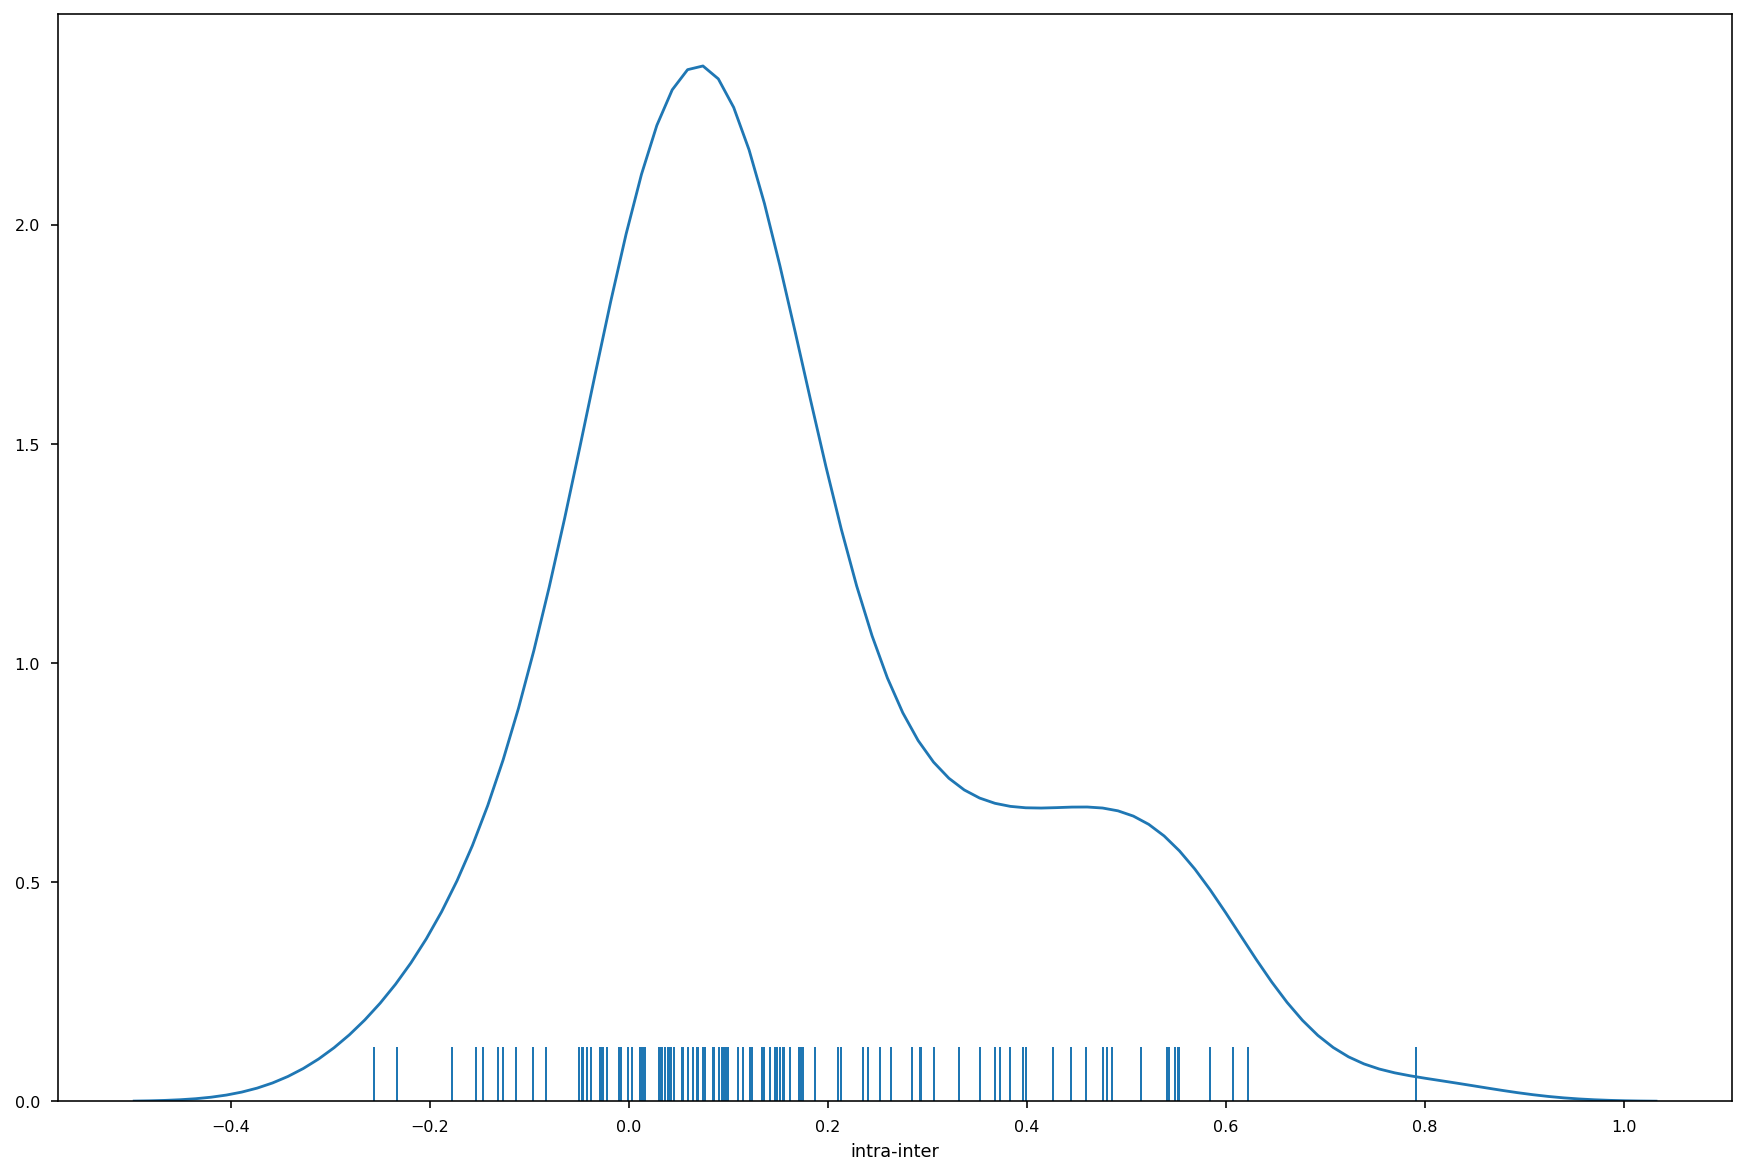

In [127]:
plt.figure(figsize=(15, 10))
sns.distplot(df_both['intra-inter'], hist=False, rug=True);
plt.show()

# Compare CUDA stream with Intra-SM

In [46]:
df_seq = pd.read_pickle(os.path.join(PKL_PATH, 'seq.pkl'))

In [60]:
apps = ['nvd_blackscholes-0', 'rod_lavamd-0']

width=800
xlim = 5200000

gen_altair.draw_timeline_from_console(apps, 's1.txt', df_seq, title="CUDA Stream: nvd_blackscholes comes first", width=width, xmax=xlim).display()
gen_altair.draw_timeline_from_console(apps, 's2.txt', df_seq, title="CUDA Stream: rod_lavamd comes first", width=width, xmax=xlim).display()
print("nvd_blackscholes-0: 16 CTAs/SM")
print("rod_lavamd-0: 9 CTAs/SM")

gen_altair.draw_timeline_from_console(apps, 'intra.txt', df_seq, title="Intra-SM", width=width, xmax=xlim).display()
print("nvd_blackscholes-0: 6 CTAs/SM")
print("rod_lavamd-0: 6 CTAs/SM")

alt.LayerChart(...)

alt.LayerChart(...)

nvd_blackscholes-0: 16 CTAs/SM
rod_lavamd-0: 9 CTAs/SM


alt.LayerChart(...)

nvd_blackscholes-0: 6 CTAs/SM
rod_lavamd-0: 6 CTAs/SM


In [59]:
apps = ['nvd_binomial-0', 'parb_stencil-0']

width=1000
xlim = None

gen_altair.draw_timeline_from_console(apps, 's1.txt', df_seq, title="CUDA Stream: nvd_binomial comes first", width=width, xmax=xlim).display()
gen_altair.draw_timeline_from_console(apps, 's2.txt', df_seq, title="CUDA Stream: parb_stencil comes first", width=width, xmax=xlim).display()
print("nvd_binomial-0: 12-13 CTAs/SM (max 16 CTAs/SM)")
print("parb_stencil-0: 12-13 CTAs/SM (max 16 CTAs/SM)")

gen_altair.draw_timeline_from_console(apps, 'intra.txt', df_seq, title="Intra-SM", width=width, xmax=xlim).display()
print("nvd_binomial-0: 8 CTAs/SM")
print("parb_stencil-0: 4 CTAs/SM")

alt.LayerChart(...)

alt.LayerChart(...)

nvd_binomial-0: 12-13 CTAs/SM (max 16 CTAs/SM)
parb_stencil-0: 12-13 CTAs/SM (max 16 CTAs/SM)


alt.LayerChart(...)

nvd_binomial-0: 8 CTAs/SM
parb_stencil-0: 4 CTAs/SM


In [52]:
apps = ['nvd_fdtd3d-0', 'rod_heartwall-0']

width=1600
xlim = 2300000

gen_altair.draw_timeline_from_console(apps, 's1.txt', df_seq, title="CUDA Stream: nvd_fdtd3d comes first", width=width, xmax=xlim).display()
print("nvd_fdtd3d-0: 1 CTAs/SM")
print("rod_heartwall-0: 1 CTAs/SM")

gen_altair.draw_timeline_from_console(apps, 's2.txt', df_seq, title="CUDA Stream: rod_heartwall comes first", width=width, xmax=xlim).display()
print("nvd_fdtd3d-0: 1 CTAs/SM")
print("rod_heartwall-0: 1 CTAs/SM")

gen_altair.draw_timeline_from_console(apps, 'intra.txt', df_seq, title="Intra-SM", width=width, xmax=xlim).display()
print("nvd_fdtd3d-0: 1 CTAs/SM")
print("rod_heartwall-0: 1 CTAs/SM")

alt.LayerChart(...)

nvd_fdtd3d-0: 1 CTAs/SM
rod_heartwall-0: 1 CTAs/SM


alt.LayerChart(...)

nvd_fdtd3d-0: 1 CTAs/SM
rod_heartwall-0: 1 CTAs/SM


alt.LayerChart(...)

nvd_fdtd3d-0: 1 CTAs/SM
rod_heartwall-0: 1 CTAs/SM
